<a href="https://colab.research.google.com/github/danielmlow/tutorials/blob/main/speech/UROP_Library_Implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Authors: Jennifer Sun
Template: Daniel M Low
License: See license in github repository
'''

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.io import wavfile


# mount Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

input_dir = '/content/drive/My Drive/research_assistans/jennifer/wav_data/'
smoker = "smoker.wav"
forecaster = "forecaster.wav"

smoker_samplerate, smoker_data = wavfile.read(input_dir + smoker)
forecaster_samplerate, forecaster_data = wavfile.read(input_dir + forecaster)
# print(smoker_samplerate, smoker)


Mounted at /content/drive


FileNotFoundError: ignored

# Record audio from microphone

https://colab.research.google.com/gist/ricardodeazambuja/03ac98c31e87caf284f7b06286ebf7fd/microphone-to-numpy-array-from-your-browser-in-colab.ipynb#scrollTo=KpgBQHO_rGXR

In [ ]:
!pip install ffmpeg-python
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
audio, sr = get_audio()

IndexError: ignored

# Extract Function

Extracts features from multiple different libraries including (...) using the best implementation from each.

In [ ]:
!pip install opensmile

In [ ]:
import opensmile

def load_egemaps(audio, feature_level):
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=feature_level,
    )
    return smile.process_file(audio)

def extract(list_audio_file_paths, list_feature_names, feature_level = "func"):
    """
    list_audio_file_paths: list of file audio paths
    list_feature_names: names of features to be extracted
    feature_level: either "func" for functioinals or "lld" for low level descriptors
    """
    # access audio file(s) and extract feature_level data
    for audio in list_audio_file_paths:
        samplerate, data = wavfile.read(audio)
        egemaps = load_egemaps(audio, feature_level)

        if feature_level != "func" and feature_level != "lld":
            print("""error: feature_level should either be 'func' for functioinals
                  or 'lld' for low level descriptors""")
            return 0

        # best implementation for each feature
        implementation = {
            "lld_f0": (egemaps, "F0semitoneFrom27.5Hz_sma3nz"),
            "func_f0": (egemaps, "F0semitoneFrom27.5Hz_sma3nz_amean"),
            "lld_loudness": (egemaps, "Loudness_sma3"),
        }

        df = pd.DataFrame()
        for feature in list_feature_names:
            lib, key = implementation[feature_level + "_" + feature]
            df = df.append(lib[key])
            # print(lib[key])
        print(df)


In [ ]:
extract([input_dir + smoker], ["f0", "loudness"], "lld")

file                        /content/drive/My Drive/jennifer/wav_data/smoker.wav  \
start                                                            0 days 00:00:00   
end                                                       0 days 00:00:00.020000   
F0semitoneFrom27.5Hz_sma3nz                                           0.000000     
Loudness_sma3                                                         0.001034     

file                                                                       \
start                       0 days 00:00:00.010000 0 days 00:00:00.020000   
end                         0 days 00:00:00.030000 0 days 00:00:00.040000   
F0semitoneFrom27.5Hz_sma3nz               0.000000               0.000000   
Loudness_sma3                             0.001034               0.003606   

file                                                                       \
start                       0 days 00:00:00.030000 0 days 00:00:00.040000   
end                         0 days 00:0

<ipython-input-44-ff32975253f0>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(lib[key])
<ipython-input-44-ff32975253f0>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(lib[key])


# Parselmouth

In [ ]:
!pip install praat-parselmouth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 45.6 MB/s eta 0:00:00


In [ ]:
import parselmouth
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# snd = parselmouth.Sound(input_dir + smoker)
snd = parselmouth.Sound(audio, sr)

pitch = snd.to_pitch()
# # print(pitch)
# df = pd.DataFrame(np.column_stack([pitch]))
# df.to_csv("processed_results.csv", index=False)

Spectrogram + Intensity

<ipython-input-36-595f2da7649e>:3: RuntimeWarning: divide by zero encountered in log10
  sg_db = 10 * np.log10(spectrogram.values)


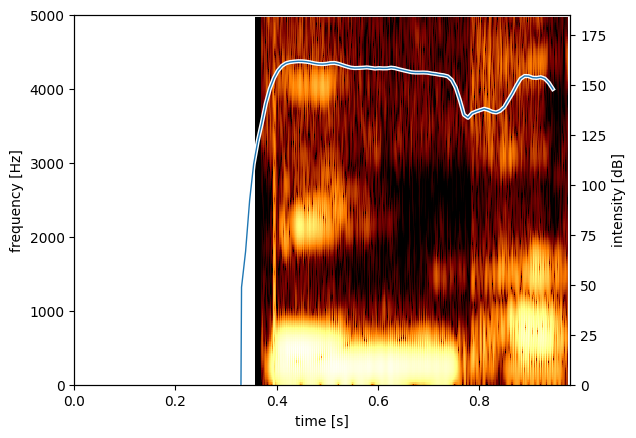

In [ ]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")


intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

Pitch

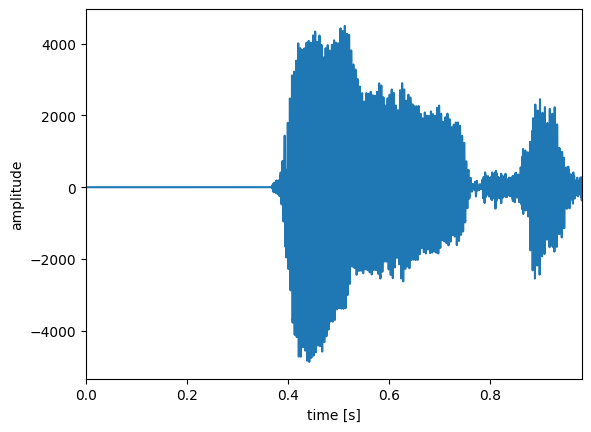

In [ ]:
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.savefig("parselmouth_pitch.png")

# Allie

In [ ]:
!git clone https://github.com/jim-schwoebel/allie.git

Cloning into 'allie'...
remote: Enumerating objects: 20167, done.
remote: Counting objects: 100% (767/767), done.
remote: Compressing objects: 100% (391/391), done.
remote: Total 20167 (delta 585), reused 501 (delta 361), pack-reused 19400
Receiving objects: 100% (20167/20167), 267.50 MiB | 15.39 MiB/s, done.
Resolving deltas: 100% (11297/11297), done.
Updating files: 100% (4770/4770), done.


In [ ]:
%cd allie/features/audio_features

In [ ]:
!pip install SpeechRecognition

In [ ]:
!pip install wheel
!pip install numba==0.48

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for numba: filename=numba-0.48.0-cp39-cp39-linux_x86_64.whl size=2866602 sha256=8e6d8c2514a8af34ddc063c41f87d007ed6b8b16f895dc30645d569051192895
  Stored in directory: /root/.cache/pip/wheels/67/f4/34/43855bda1e661dc1afedcb295d313a510239d901336fd636c3
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for llvmlite
  Running setu

In [ ]:
!python3 featurize.py /content/allie/features/train_dir/males

Traceback (most recent call last):
  File "/content/allie/features/audio_features/featurize.py", line 449, in <module>
    import librosa_features
  File "/content/allie/features/audio_features/librosa_features.py", line 45, in <module>
    import librosa, os
  File "/usr/local/lib/python3.9/dist-packages/librosa/__init__.py", line 12, in <module>
    from . import core
  File "/usr/local/lib/python3.9/dist-packages/librosa/core/__init__.py", line 109, in <module>
    from .time_frequency import *  # pylint: disable=wildcard-import
  File "/usr/local/lib/python3.9/dist-packages/librosa/core/time_frequency.py", line 10, in <module>
    from ..util.exceptions import ParameterError
  File "/usr/local/lib/python3.9/dist-packages/librosa/util/__init__.py", line 71, in <module>
    from . import decorators
  File "/usr/local/lib/python3.9/dist-packages/librosa/util/decorators.py", line 9, in <module>
    from numba.decorators import jit as optional_jit
ModuleNotFoundError: No module named 'n

In [ ]:
import os 
cwd= os.getcwd()
print (cwd)

/content/allie/features/audio_features


# Disvoice

In [ ]:
!git clone https://github.com/jcvasquezc/disvoice
!cd disvoice

Cloning into 'disvoice'...
remote: Enumerating objects: 1178, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 1178 (delta 141), reused 242 (delta 135), pack-reused 920
Receiving objects: 100% (1178/1178), 52.35 MiB | 18.55 MiB/s, done.
Resolving deltas: 100% (685/685), done.


In [ ]:
!ls

disvoice  drive  parselmouth_pitch.png	sample_data




# EgeMAPS

In [ ]:
!pip install opensmile

In [ ]:
filename = forecaster

import opensmile

#FUNCTIONALS

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level="func",
)

# functionals = smile.process_file(input_dir + filename)
functionals = smile.process_signal(audio, sr)
# print(functionals.columns)


# LOW LEVEL DESCRIPTORS

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level="lld",
)

llds = smile.process_signal(audio, sr)
# llds = smile.process_file(input_dir + filename)

F0

[]


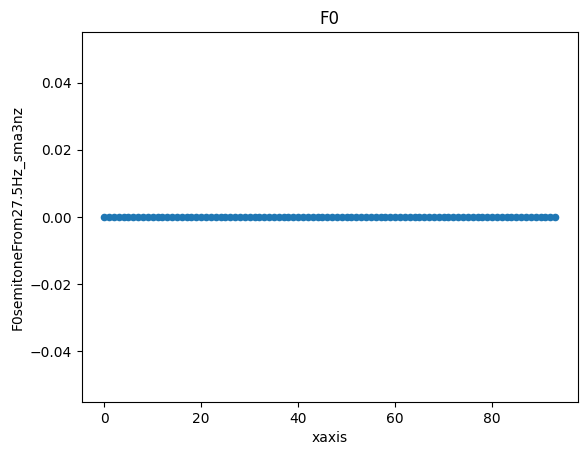

In [ ]:
f0 = pd.DataFrame(llds["F0semitoneFrom27.5Hz_sma3nz"])
xaxis = np.arange(len(f0))
f0["xaxis"] = xaxis

f0.plot(x="xaxis", y="F0semitoneFrom27.5Hz_sma3nz", kind='scatter', title="F0")	

print([x for x in llds["F0semitoneFrom27.5Hz_sma3nz"] if x != 0])

Jitter

<Axes: title={'center': 'Jitter (Local)'}, xlabel='xaxis', ylabel='jitterLocal_sma3nz'>

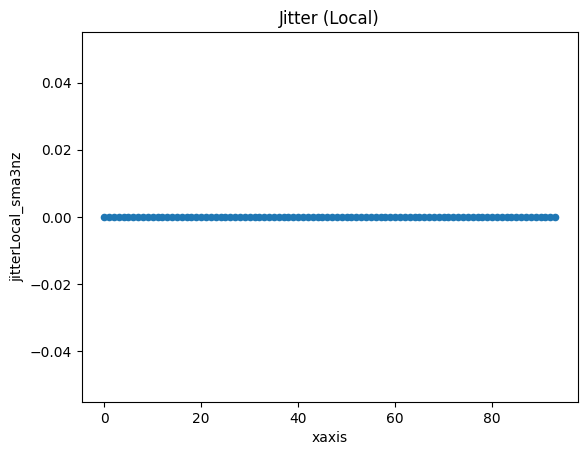

In [ ]:
jl = pd.DataFrame(llds["jitterLocal_sma3nz"])
xaxis = np.arange(0, len(jl))
jl["xaxis"] = xaxis
jl.plot(x="xaxis", y="jitterLocal_sma3nz", kind='scatter', title="Jitter (Local)")	

Energy

In [ ]:
energy = pd.DataFrame(llds["pcm_RMSenergy_sma"])
xaxis = np.arange(len(energy))
energy["xaxis"] = xaxis
energy.plot(x="xaxis", y="pcm_RMSenergy_sma", kind='scatter', title="Energy")	

print(llds["pcm_RMSenergy_sma"])

KeyError: ignored

In [ ]:
import os
!ls
os.getcwd()

# CPP

In [ ]:
!git clone https://github.com/satvik-dixit/CPP.git
%cd CPP

In [ ]:
%ls
!python3 cpp.py

audio_files/                 cpp.py                   images/
cepstrum_methods_demo.ipynb  cpp_single_window.ipynb  README.md
cpp_demo.ipynb               cpp_vfp_demo.ipynb
cpp_matlab_implementation/   files/


In [ ]:
import numpy as np
import scipy.signal 
import matplotlib.pyplot as plt
import scipy.io.wavfile
import io 
import IPython
from IPython.display import Image
import math
import numpy.matlib

def cpp_plot(x, fs, pitch_range): 
    """
    Plots the cepstral peak prominence for a given signal 

    Parameters
    -----------
    x: ndarray
        The audio signal
    fs: integer
        The sampling frequency
    pitch_range: list of 2 elements
        The pitch range where a peak is searched for

    """
    # Quefrency
    frameLen = len(x)
    NFFT = 2**(math.ceil(np.log(frameLen)/np.log(2)))
    quef = np.linspace(0, frameLen/1000, NFFT)

    # Allowed quefrency range
    quef_lim = [int(np.round_(fs/pitch_range[1])), int(np.round_(fs/pitch_range[0]))]
    quef_seq = range(quef_lim[0]-1, quef_lim[1])
    
    # High-pass filtering
    HPfilt_b = [1 - 0.97]
    x = scipy.signal.lfilter( HPfilt_b, 1, x )
    
    # FrameMat
    frameMat = np.zeros(NFFT)
    frameMat[0: frameLen] = x

    # Hanning
    def hanning(N):
        x = np.array([i/(N+1) for i in range(1,int(np.ceil(N/2))+1)])
        w = 0.5-0.5*np.cos(2*np.pi*x)
        w_rev = w[::-1]
        return np.concatenate((w, w_rev[int((np.ceil(N%2))):]))
    win = hanning(frameLen)
    winmat = np.matlib.repmat(win, 1, 1)
    frameMat = frameMat[0:frameLen]*winmat
    frameMat = frameMat[0]
    
    # Cepstrum
    SpecMat = np.abs(np.fft.fft(frameMat))
    SpecdB = 20*np.log10(SpecMat)
    ceps = 20*np.log10(np.abs(np.fft.fft(SpecdB)))
    
    # Finding the peak
    ceps_lim = ceps[quef_seq]
    ceps_max = np.max(ceps_lim)
    max_index = np.argmax(ceps_lim)

    # Normalisation
    ceps_mean = np.mean(ceps_lim)
    p = np.polyfit(quef_seq, ceps_lim,1)
    ceps_norm = np.polyval(p, quef_seq[max_index])

    cpp = ceps_max-ceps_norm
    
    print('ceps_max: {}'.format(ceps_max))
    print('ceps_norm: {}'.format(ceps_norm))
    print('cpp: {}'.format(cpp))
    
    # Plotting 
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.plot(quef[quef_seq], ceps_lim)
    ax.plot(quef[quef_seq], np.poly1d(p)(quef_seq))
    ax.plot(quef[quef_seq][max_index], ceps_max, marker="o",markeredgecolor="red", markerfacecolor="red")
    ax.plot(quef[quef_seq][max_index], np.poly1d(p)(quef_seq)[max_index], marker="o", markeredgecolor="red", markerfacecolor="red")

    ax.set_xlabel('quefrency(s)')
    ax.set_ylabel('log magnitude(dB)')
    ax.set_title('Cepstrum')

ceps_max: 86.49423940886585
ceps_norm: 67.76136215415423
cpp: 18.732877254711624


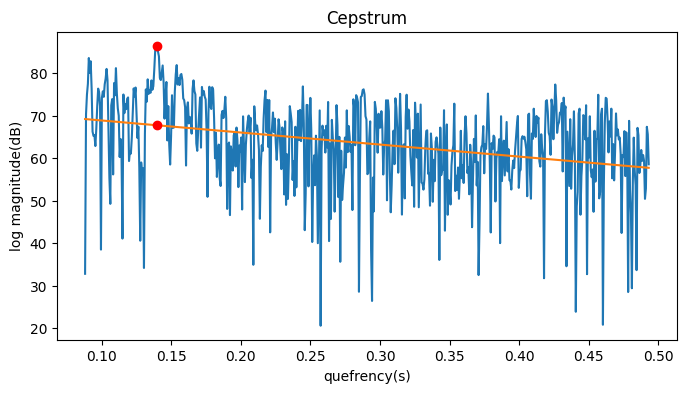

In [ ]:
# IPython.display.Audio(smoker_data, rate = smoker_samplerate)
IPython.display.Audio(audio, rate = sr)

# fs, signal = scipy.io.wavfile.read(input_dir + "forecaster.wav")
fs, signal = sr, audio
cpp_plot(x=signal, fs=fs, pitch_range=[60, 333.3])

# Importing Libraries

In [ ]:
!pip install pyAudioAnalysis
!git clone https://github.com/jcvasquezc/DisVoice.git
!pip install praat-parselmouth


